In [7]:
%pip install polars --quiet
%pip install matplotlib --quiet
%pip install seaborn --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import pandas as pd
import numpy as np

In [9]:
input_url = "s3://market-data-dev-142571790518/aggregated/market_prices"

In [10]:
df_raw = pd.read_parquet(input_url)

# Start from here

In [11]:
df = df_raw.copy()

In [12]:
df.sort_values(by=["processed_timestamp"], inplace=True)
df.reset_index(drop=True, inplace=True)
df["processed_timestamp"] = pd.to_datetime(df["processed_timestamp"])

# Basic clean up

In [13]:
# Drop duplicates
df.drop_duplicates(subset=["processed_timestamp","type_id"], inplace=True)

In [14]:
# Cut the maximum price to 1.5 times the 90th percentile
q1 = df['average_price'].quantile(0.25)
q3 = df['average_price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df.loc[df['average_price'] > upper_bound, 'average_price'] = upper_bound

# Create hist. features

In [15]:
for n in range(1,5):
    df[f"price_t-{n}"] = df.groupby("type_id").shift(n)["average_price"]

In [16]:
df["5_day_rolling_mean"] = df.groupby('type_id')['average_price'].rolling(window=5,min_periods=1).mean().reset_index(level=0, drop=True)
df["5_day_rolling_std"] = df.groupby('type_id')['average_price'].rolling(window=5,min_periods=1).std().reset_index(level=0, drop=True)

In [17]:
# Price changes
df["price_change"] = df.groupby('type_id')['average_price'].diff().ffill().bfill()
# df["price_pct_change"] = df["average_price"].pct_change(fill_method=None)


# Create Time based Features

In [18]:
df['day_of_week'] = df["processed_timestamp"].dt.day_of_week # 0 = Monday, 6 = Sunday
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # 1 if weekend, 0 otherwise
df['month'] = df["processed_timestamp"].dt.month
df['hour'] = df["processed_timestamp"].dt.hour

# Pop out the time

In [19]:
date_time = pd.to_datetime(df.pop('processed_timestamp'), format='%Y-%m-%d %H:%M:%S').drop_duplicates()

# Sample one to look at it

In [20]:
df_sub = df.loc[df["type_id"]==81901]
df_sub.head()

,type_id,date,adjusted_price,average_price,source_path,avg_daily_price,min_daily_price,max_daily_price,record_count,price_t-1,price_t-2,price_t-3,price_t-4,5_day_rolling_mean,5_day_rolling_std,price_change,day_of_week,is_weekend,month,hour
1408,81901,2025-04-05,0.0,500.0,raw/api-data/prices/year=2025/month=04/day=05/...,0.0,0.0,0.0,2,NaN,NaN,NaN,NaN,500.0,NaN,0.0,5,1,4,22
33863,81901,2025-04-06,0.0,500.0,raw/api-data/prices/year=2025/month=04/day=06/...,0.0,0.0,0.0,2,500.0,NaN,NaN,NaN,500.0,0.0,0.0,6,1,4,10
49528,81901,2025-04-06,0.0,500.0,raw/api-data/prices/year=2025/month=04/day=06/...,0.0,0.0,0.0,2,500.0,500.0,NaN,NaN,500.0,0.0,0.0,6,1,4,22
63649,81901,2025-04-07,0.0,500.0,raw/api-data/prices/year=2025/month=04/day=07/...,0.0,0.0,0.0,2,500.0,500.0,500.0,NaN,500.0,0.0,0.0,0,0,4,10
81229,81901,2025-04-07,0.0,500.0,raw/api-data/prices/year=2025/month=04/day=07/...,0.0,0.0,0.0,2,500.0,500.0,500.0,500.0,500.0,0.0,0.0,0,0,4,22


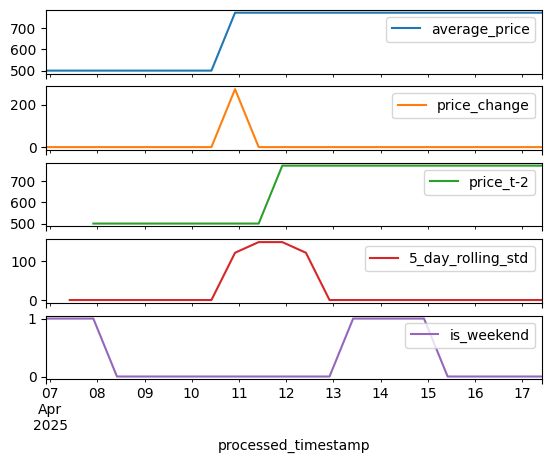

In [21]:
df_sub = df.loc[(df["type_id"] == 81901)]

plot_cols = ['average_price','price_change','price_t-2','5_day_rolling_std','is_weekend']
plot_features = df_sub[plot_cols]
time_mask = -len(plot_features)
plot_features.index = date_time[time_mask:]
_ = plot_features.plot(subplots=True)